In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns

Creating the SQLAlchemy Engine

In [2]:

db_username = 'postgres'
db_password = 'Anurag@682'
db_host = 'localhost'
db_port = '5432'
db_name = 'bank_marketing'


# URL-encode the password
encoded_db_password = urllib.parse.quote_plus(db_password)

# Creating the connection string
engine = create_engine(f'postgresql+psycopg2://{db_username}:{encoded_db_password}@{db_host}:{db_port}/{db_name}')

print("Connection string created successfully!")

try:
    with engine.connect() as connection:
        print("Successfully connected to the database!")
except Exception as e:
    print(f"Error connecting: {e}")


Connection string created successfully!
Successfully connected to the database!


Our password had @ which is causing trouble in parsing the database correctly therefore we had to encode using URL

Loading the clients Table into pandas

In [3]:
df_clients = pd.read_sql("SELECT * FROM bank_marketing.clients", engine )



In [4]:
df_clients.head()

,client_id,age,job,marital,education,Default,housing,loan,age_group,financial_risk
0,29201,56,blue-collar,married,basic.4y,no,no,no,Senior_adults,low_risk
1,37259,27,blue-collar,married,high.school,no,no,no,Young_adults,low_risk
2,15290,31,self-employed,married,professional.course,no,no,no,Adults,low_risk
3,16663,54,housemaid,married,basic.4y,no,yes,no,Senior_adults,moderate_risk
4,20778,36,admin,married,university.degree,no,no,no,Adults,low_risk


We had this issue , that the single value "unknown" was incessant across the client table therefore for treating it , we are gonna perform relevant operation 

In [5]:
unkown_counts = (df_clients == 'unknown').sum()
print(unkown_counts[unkown_counts > 0])


Series([], dtype: int64)


We are gonna follow the common approach here

In [6]:
df_clients.dtypes

client_id          int64
age                int64
job               object
marital           object
education         object
Default           object
housing           object
loan              object
age_group         object
financial_risk    object
dtype: object

Check Unique Job Titles

In [7]:
df_clients['education'].value_counts() #could check in-turn which column contains how much distinct values


education
university.degree      13230
high.school             9832
basic.9y                6045
professional.course     5455
basic.4y                4316
basic.6y                2292
illiterate                18
Name: count, dtype: int64

Replacing "unknown" with "Not specified" in job

In [8]:
df_clients['job'] = df_clients['job'].replace('unknown','Not specified')


Replacing "unknown" in marital

In [9]:
df_clients["marital"] = df_clients["marital"].replace("unknown", "Not specified")


Replacing "unknown" with NaN in education gives you flexibility later for imputation based on other columns like job, age, or marital.

  

In [10]:
df_clients['education'] = df_clients['education'].replace('unknown',np.nan)

Replacing "unknown" with "Not specified" in default, housing, and loan



In [11]:
cols_to_update = ['Default','housing','loan']

for col in cols_to_update:
    df_clients[col] = df_clients[col].replace('unknown','Not specified')


df_clients.to_csv('Clients.csv',index=False)

Renaming the Default column in our pandas DataFrame to match SQL column name:



In [12]:
df_clients.rename(columns={"Default": "default"}, inplace=True)


Uploading the cleaned DataFrame to a temporary table

In [13]:
df_clients.to_sql("clients_temp", engine, schema="bank_marketing", if_exists="replace", index=False)

188

Using SQL to update the original clients table

In [14]:

from sqlalchemy import text

update_query = """
UPDATE bank_marketing.clients AS orig
SET
    job = temp.job,
    marital = temp.marital,
    education = temp.education,
    "Default" = temp."default",
    housing = temp.housing,
    loan = temp.loan
FROM bank_marketing.clients_temp AS temp
WHERE orig.client_id = temp.client_id;
"""

with engine.begin() as conn:
    conn.execute(text(update_query))



Droping the temporary table

In [15]:
with engine.begin() as conn:
    conn.execute(text("DROP TABLE bank_marketing.clients_temp;"))


Time to make sense out of these tables too:

In [16]:
df_contacts = pd.read_sql("SELECT * FROM bank_marketing.contacts", engine)
df_campaigns = pd.read_sql("SELECT * FROM bank_marketing.campaigns", engine)
df_subscriptions = pd.read_sql("SELECT * FROM bank_marketing.subscription", engine)

In [17]:
df = df_clients.merge(df_subscriptions, on="client_id") \
               .merge(df_contacts, on="client_id") \
               .merge(df_campaigns, on="client_id")


In [18]:
df.head()

,client_id,age,job,marital,education,default,housing,loan,age_group,financial_risk,...,mnth,day_of_week,duration,call_duration_band,campaign_id,campaign,pdays,previous,poutcome,repeated_contacts
0,29201,56,blue-collar,married,basic.4y,no,no,no,Senior_adults,low_risk,...,apr,fri,422,5-10min,29201,1,999,0,nonexistent,1
1,37259,27,blue-collar,married,high.school,no,no,no,Young_adults,low_risk,...,aug,fri,192,3-5min,37259,1,4,1,success,1
2,15290,31,self-employed,married,professional.course,no,no,no,Adults,low_risk,...,jul,thu,505,5-10min,15290,3,999,0,nonexistent,2-3
3,16663,54,housemaid,married,basic.4y,no,yes,no,Senior_adults,moderate_risk,...,jul,wed,198,3-5min,16663,13,999,0,nonexistent,10+
4,20778,36,admin,married,university.degree,no,no,no,Adults,low_risk,...,aug,wed,69,1-3min,20778,1,999,0,nonexistent,1


In [19]:
df_contacts['contact'].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [20]:
df_contacts['mnth'].value_counts().sort_index()

mnth
apr     2632
aug     6178
dec      182
jul     7174
jun     5318
mar      546
may    13769
nov     4101
oct      718
sep      570
Name: count, dtype: int64

In [21]:
df_contacts['day_of_week'].value_counts()

day_of_week
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: count, dtype: int64

In [22]:
df_contacts["duration"].describe()


count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

Are duration values skewed or have outliers?

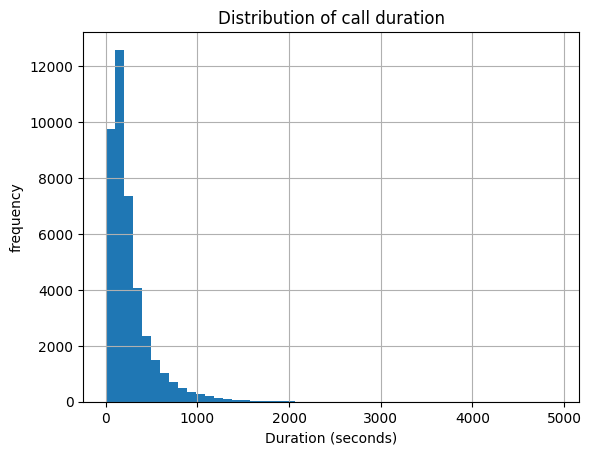

In [23]:
df_contacts['duration'].hist(bins=50)
plt.title('Distribution of call duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('frequency')
plt.show()

clearly there are outliers in duration column

Filter Out Meaningless Calls (e.g., 0 duration)

In [24]:
df_contacts = df_contacts[df_contacts['duration'] > 0]

trim top 1–5%

In [25]:
df_contacts['duration'].quantile(0.95) #Get 95th percentile:

np.float64(752.8499999999985)

In [26]:
df_contacts = df_contacts[df_contacts['duration'] <= 720]

In [27]:
df_contacts["duration"].describe()

count    38895.000000
mean       211.561049
std        153.101239
min          1.000000
25%         98.000000
50%        170.000000
75%        286.000000
max        720.000000
Name: duration, dtype: float64

In [28]:
df_contacts["duration_group"] = pd.cut(
    df_contacts["duration"],
    bins=[0, 60, 180, 300, 600, df_contacts["duration"].max()],
    labels=["<1min", "1–3min", "3–5min", "5–10min", "10min+"]
)


In [29]:
df_contacts['duration_group'].value_counts()

duration_group
1–3min     16419
3–5min      9279
5–10min     7740
<1min       4282
10min+      1175
Name: count, dtype: int64

In [30]:
df_contacts['contact'].value_counts()

contact
cellular     24627
telephone    14268
Name: count, dtype: int64

In [31]:
df.groupby("contact")["y"].value_counts(normalize=False).unstack()

y,no,yes
contact,,
cellular,22291,3853
telephone,14257,787


In [32]:
df_contacts['mnth'].value_counts().sort_index()

mnth
apr     2458
aug     5904
dec      167
jul     6672
jun     5057
mar      533
may    13026
nov     3876
oct      674
sep      528
Name: count, dtype: int64

In [33]:
df.groupby("mnth")["y"].value_counts(normalize=False).unstack().round(2)


y,no,yes
mnth,,
apr,2093,539
aug,5523,655
dec,93,89
jul,6525,649
jun,4759,559
mar,270,276
may,12883,886
nov,3685,416
oct,403,315


In [34]:
df_contacts['day_of_week'].value_counts()

df.groupby('day_of_week')['y'].value_counts().unstack().round(2)

y,no,yes
day_of_week,,
fri,6981,846
mon,7667,847
thu,7578,1045
tue,7137,953
wed,7185,949


In [35]:
df["duration_group"] = pd.cut(
    df["duration"],
    bins=[0, 60, 180, 300, 600, df["duration"].max()],
    labels=["<1min", "1–3min", "3–5min", "5–10min", "10min+"]
)


In [36]:
df.groupby("duration_group")["y"].value_counts(normalize=False).unstack().round(5)


C:\Users\annur\AppData\Local\Temp\ipykernel_15672\4235303939.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("duration_group")["y"].value_counts(normalize=False).unstack().round(5)


y,no,yes
duration_group,,
<1min,4281,1
1–3min,15856,563
3–5min,8325,954
5–10min,6302,1438
10min+,1780,1684


Campaign table evaluation 

In [37]:
df_campaigns.info()
df_campaigns.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   campaign_id        41188 non-null  int64 
 1   client_id          41188 non-null  int64 
 2   campaign           41188 non-null  int64 
 3   pdays              41188 non-null  int64 
 4   previous           41188 non-null  int64 
 5   poutcome           41188 non-null  object
 6   repeated_contacts  41188 non-null  object
dtypes: int64(5), object(2)
memory usage: 2.2+ MB


,campaign_id,client_id,campaign,pdays,previous
count,41188.00000,41188.00000,41188.000000,41188.000000,41188.000000
mean,20594.50000,20594.50000,2.567593,962.475454,0.172963
std,11890.09578,11890.09578,2.770014,186.910907,0.494901
min,1.00000,1.00000,1.000000,0.000000,0.000000
25%,10297.75000,10297.75000,1.000000,999.000000,0.000000
50%,20594.50000,20594.50000,2.000000,999.000000,0.000000
75%,30891.25000,30891.25000,3.000000,999.000000,0.000000
max,41188.00000,41188.00000,56.000000,999.000000,7.000000


Plot the distribution

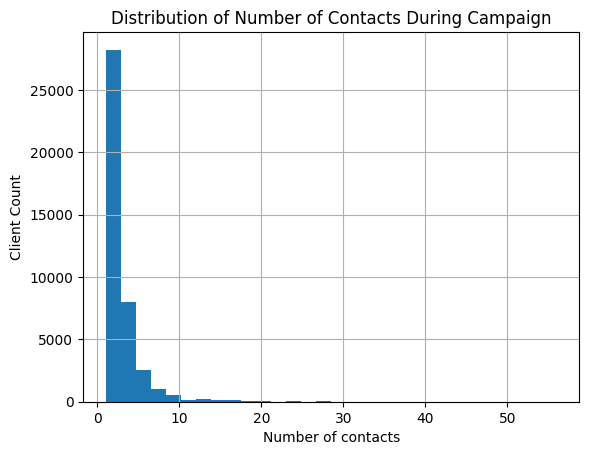

In [38]:
df_campaigns['campaign'].hist(bins=30)
plt.title("Distribution of Number of Contacts During Campaign")
plt.xlabel('Number of contacts')
plt.ylabel('Client Count')
plt.show()

In [39]:
df['campaign_group'] = pd.cut(
    df['campaign'],
    bins=[0,1,3,5,10 , df['campaign'].max()],
    labels = ['1','2-3','4-5','6-10','10+']
)

In [40]:
result = df.groupby('campaign_group')['y'].value_counts(normalize=True).unstack().round(3)*100
print(result)

y                 no   yes
campaign_group            
1               87.0  13.0
2-3             88.8  11.2
4-5             91.3   8.7
6-10            93.7   6.3
10+             96.9   3.1


C:\Users\annur\AppData\Local\Temp\ipykernel_15672\815723473.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby('campaign_group')['y'].value_counts(normalize=True).unstack().round(3)*100


In [41]:
result['yes'].sort_values(ascending=False)

campaign_group
1       13.0
2-3     11.2
4-5      8.7
6-10     6.3
10+      3.1
Name: yes, dtype: float64

In [42]:
conversion_rate = result['yes'] / (result['yes'] + result['no']) * 100
conversion_rate.round(2)

campaign_group
1       13.0
2-3     11.2
4-5      8.7
6-10     6.3
10+      3.1
dtype: float64

In [43]:
df["pdays"].value_counts().head()


pdays
999    39673
3        439
6        412
4        118
9         64
Name: count, dtype: int64

In [44]:
df_campaigns["pdays"] = pd.to_numeric(df["pdays"], errors='coerce')  # just in case
df_campaigns["pdays_group"] = df_campaigns["pdays"].apply(lambda x: "not_contacted_recently " if x == 999 else "contacted_before")


In [45]:
df_campaigns[df_campaigns["pdays"] == 999]["pdays_group"].value_counts()


pdays_group
not_contacted_recently     39673
Name: count, dtype: int64

In [46]:
df_campaigns["pdays_group"].value_counts()


pdays_group
not_contacted_recently     39673
contacted_before            1515
Name: count, dtype: int64

In [47]:
df_merged = df_campaigns.merge(df_subscriptions,on = 'client_id')

In [50]:
result = df_merged.groupby(["pdays_group", "poutcome" ])["y"].value_counts(normalize=False).unstack().round(4)
result


y                                       no   yes
pdays_group             poutcome                
contacted_before        failure         90     7
                        nonexistent   1265   138
                        success          5    10
not_contacted_recently  failure       3557   598
                        nonexistent  31157  3003
                        success        474   884

In [51]:
df_merged.groupby(['previous'])['y'].value_counts(normalize=False).unstack().round(4)

y,no,yes
previous,,
0,32422.0,3141.0
1,3594.0,967.0
2,404.0,350.0
3,88.0,128.0
4,32.0,38.0
5,5.0,13.0
6,2.0,3.0
7,1.0,NaN
